# Homework-2
**Name: Piyush Chawla**

## Part 1: Business Understanding

This assignment uses wine_quality dataset. The dataset contains details about wine samples in the form of attributes that explain chemical composition if each sample, obtained by physiochemical tests [Cortez et al., 2009](https://www.sciencedirect.com/science/article/pii/S0167923609001377). The samples are of *Vinho Verde*, a type of Portuguese wine that has both red and white variants. The datasets (red and white wine) were released by Cortez et al. in their work "Modeling wine preferences by data mining from physicochemical properties". In this study, we are limiting the analysis to the only red wine data because red and white wine have their distinct characteristics (Cortez et al). The dataset was generated by assimilation of wine data released by CVRVV, an organization in Portugal that aims at improving quality and marketing of *Vinho Verde*, between May-2004 and February-2007. The most obvious question is "Can we classify wine samples based on their quality by leveraging other attributes?". Also, we might be interested in finding how certain attributes like pH affect the quality of the wine, this is especially important while manufacturing the wine.

## Part 2: Data Understanding

The dataset contains 1599 wine samples and 12 attributes.
<br>
1 - fixed acidity 
<br>
2 - volatile acidity 
<br>
3 - citric acid 
<br>
4 - residual sugar 
<br>
5 - chlorides 
<br>
6 - free sulfur dioxide 
<br>
7 - total sulfur dioxide 
<br>
8 - density 
<br>
9 - pH 
<br>
10 - sulphates 
<br>
11 - alcohol 
<br>
12 - quality (score between 0 and 10)
<br>

The output below shows details about attributes. We see that there are no null (missing) values. Also, all the attributes are continuous float values except the dependent variable "quality", which is an integer-valued attribute. Below we analyze the attributes by finding outliers and visualizing inter-attribute relationships. We use different visualization methods like histogram, 2d scatter plots and 3d scatter plots.

In the code snippet below, we binarize the attribute 'quality' into two categorical values 'High' and 'Low'. We remove the attribute 'quality' and add a new attribute 'class' such that for a sample with quality greater or equal to 5, we assign it a class label 'High', and 'Low' otherwise.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
from IPython.display import HTML, display
import sys

data = pd.read_csv('winequality-red.csv',sep=';')
temp = []

# Binarization of quality
for i in range(len(data)):
    if data['quality'].iloc[i]<=5:
        temp.append('Low')
    else:
        temp.append('High')
        
data['class'] = temp
temp = list(data.keys())
temp.remove('quality')
data = data[temp]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
class                   1599 non-null object
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


### 1. Outlier Analysis

We try different heuristics to find outliers in each attribute. We start with a simple solution described [here](https://math.stackexchange.com/questions/377584/what-is-a-simple-way-to-find-the-outliers-of-an-array). For an attribute we find the first quartile, median and third quartile values. The outliers are defined as the values which are smaller and greater than first and third quartile respectively, by a "factor" of inter-quartile-range. The code snippet below gives a function that returns outliers for a given attribute.

Below we use **outliers()** function on **alcohol** attribute. The link above uses a constant "factor" of 1.5. But it can be seen that the values returned by this method are continuously increasing (mostly) and do not look like outliers. On choosing a factor of 2, we get 14.9, which looks like an outlier.

In [4]:
def outliers(att,factor):
    temp = data[att].describe()
    iqr = temp['75%']-temp['25%']
    tl = temp['25%']-factor*iqr
    th = temp['75%']+factor*iqr
    print('value\tindex')
    for i in range(len(data)):
        if data[att].iloc[i]<tl or data[att].iloc[i]>th:
            print(str(data[att].iloc[i])+'\t'+str(i))

In [5]:
outliers('alcohol',1.5)

value	index
14.0	142
14.0	144
14.0	467
14.0	588
14.9	652
14.0	821
13.6	1114
13.6	1132
13.6	1228
14.0	1269
14.0	1270
13.566666666666698	1475
13.6	1477


In [6]:
outliers('alcohol',2)

value	index
14.9	652


The table below lists the values of different 'factor' found for each attribute. The factor values are found using hit and trial strategy. Initially starting with 1.5, the value is increased in a binary search fashion.

| Attribute |  Factor  | Number of outliers |
|--|--|--|
| fixed acidity | 3 | 5 |
| volatile acidity | 2.6 | 6 |
| citric acid | 1.5 | 1 |
| residual sugar | 15 | 7 |
| chlorides | 20 | 2 |
| free sulfur dioxide | 3 | 4 |
| total sulfur dioxide | 3 | 2 |
| density | 2.5 | 2 |
| pH | -- | 0 |
| sulphates | 4 | 8 |
| alcohol | 2 | 1 |

The code below contains commented call to each attribute with the best 'factor' value corresponding to each attribute. The assumption made in this method is that the number of outliers (if any) in an attribute is a small fraction of total entries (<1%)

In [ ]:
#outliers('fixed acidity',3)
#outliers('volatile acidity',2)
#outliers('citric acid',1.5)
#outliers('residual sugar',15)
#outliers('chlorides',20)
#outliers('free sulfur dioxide',3)
#outliers('total sulfur dioxide',3)
#outliers('pH',2.5)
#outliers('sulphates',4)
#outliers('alcohol',2)

By analyzing all the above outputs, we find that entries 652, 151, 1244 are potential overall outliers because they are outliers in at least two or more attributes.

Another method for finding outliers is to sort the entries in an attribute and look for top 10 and bottom 10 values. The code below does this for attribute **total sulfur dioxide**. We see that the largest two entries look like outliers, we reached the same conclusion as in the analysis above.

In [7]:
temp = np.array(data['total sulfur dioxide'])
temp.sort()
print(temp[:10])
print(temp[-10:])

[6. 6. 6. 7. 7. 7. 7. 8. 8. 8.]
[149. 151. 151. 152. 153. 155. 160. 165. 278. 289.]


### 2. Attribute Redundancy

We compute the correlation matrix for continuous data. We see that **pH** has high correlation (-.683) with **fixed acidity** which is as expected since pH is a measure of H+ concentration in the solution (or acidity). The same is true between **citric acid** and **pH**. Since **pH** is an overall measure of acidity in the alcohol, **citric acid** and **fixed acidity** though highly correlated are not redundant attributes.

Since no attributes pairs have a very high linear correlation (correlation value > 0.9), there are no redundant attributes.

In [8]:
data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


### 3., 4. Attribute relationship with "*Class*"

We use different methods for finding relationships between independent attributes and dependent attribute, **class**. 

In the first method we find correlation of **class** attributes with the independent attributes. Since **class** is categorical attribute, we first transform it into a continous vairable by assigning integers 0 and 1 for 'High' and 'Low' repectively. The code snippet below finds the correlation of **class** with other attributes. We find that **class** has high positive correlation with **alcohol** (.435), **sulphates** (.218) and **citric acid** (.159), and negative correlation with **volatile acidity** (-.321), **total sulfar dioxide** (-.231) and **density** (-.159).

It can be seen that **fixed acidity**, **residual sugar**, **free sulfur dioxide**, **pH** have no correlation as per our first analysis.

In [9]:
from copy import copy
temp = []
for i in range(len(data)):
    if data['class'].iloc[i] == 'High':
        temp.append(1)
    else:
        temp.append(0)
data['class'] = temp
df_norm = (data - data.mean()) / (data.max() - data.min())
df_norm.corr()
data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.095093
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.321441
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.159129
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,-0.002160
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.109494
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.061757
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.231963
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.159110
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.003264
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.218072


We now use visualization methods to analyze the relationship of an attribute(s) with **Class**.

The function below plots two histograms (Red and Blue) for an attribute. The red histogram corresponds to 'High' and blue histogram corresponds to 'Low'. Since the histograms might overlap we draw another plot such that the order of red and blue histograms is reversed, for better visualization.

In [10]:
def histo(att,data = data):
    x =[]
    X=[]
    for i in range(len(data)):
        if data['class'].iloc[i]==1:
            x.append(data[att].iloc[i])
        else:
            X.append(data[att].iloc[i])
    fig = plt.figure()
    plt.hist(X,color='blue',label = 'Low');
    plt.hist(x,color='red',label = 'High');
    plt.xlabel(att)
    plt.ylabel('values')
    plt.legend()
    fig.text(.5, -0.05, 'Histogram for attribute '+att, ha='center')
    plt.show()
    
    fig = plt.figure()
    plt.hist(x,color='red',label = 'High');
    plt.hist(X,color='blue',label = 'Low');
    plt.xlabel(att)
    plt.ylabel('values')
    plt.legend()
    fig.text(.5, -0.05, 'Histogram for attribute '+att, ha='center')
    plt.show()


Below we call **histo()** function on **alcohol** attribute. We see that more "High" quality (red) samples have higher alcohol content. It looks like that increasing the alcohol content in wine increases the quality. This is in line with the correlation between **alcohol** and **class** we found above.

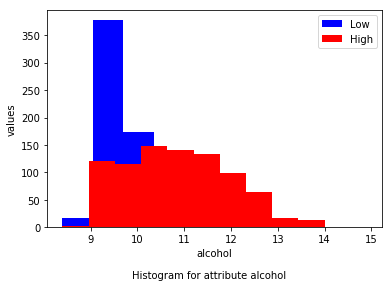

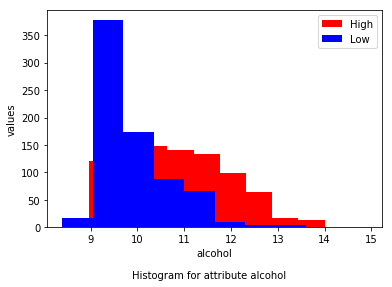

In [11]:
histo('alcohol')

We plot histogram for **sulphates** attribute. Just like **alcohol**, we see that these two attributes have noticeable positive correlation.

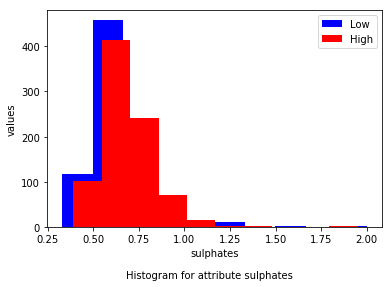

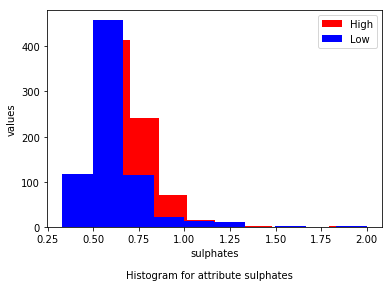

In [12]:
histo('sulphates')

The plot below shows that attributes **volatile acidity** and **class** have a negative correlation. All these plots support the analysis results we obtained from the correlation matrix method.

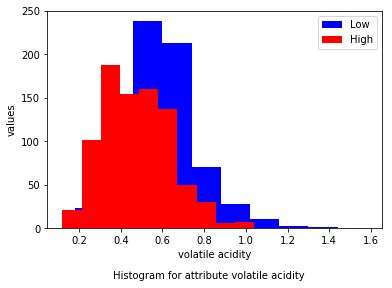

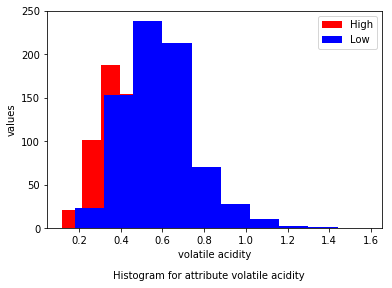

In [13]:
histo('volatile acidity')

**pH** distribution is almost the same for both the 'High' and 'Low' quality wine samples. This proves that **pH** has no correlation with **class**. Thus it has weak relationship with **class**. **pH** and **residual sugar** have weakest relationship with **class**

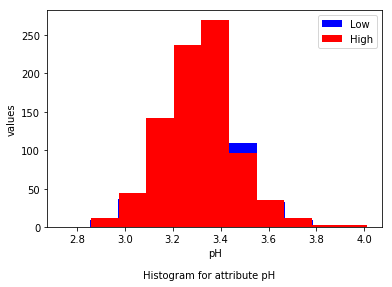

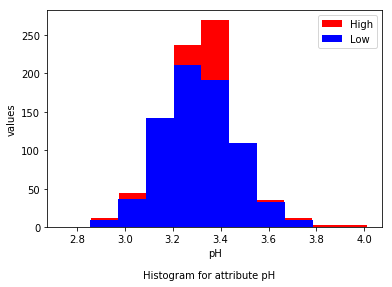

In [14]:
histo('pH')
#histo('residual sugar')

The function \_3plot shown below takes three arguments (attribute names) and plots 4 scatter plots. The first three plots are 2d scatter plots and the last plot is a 3D scatter plot. In all the plots the data is divided into two classes (red and blue). The red points correspond to samples with **class** label "High" and the blue points correspond to samples with label "Low".

In [15]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
def _3plot(a1,a2,a3):
 l1 = a1
 l2 = a2
 l3 = a3
 a1 = np.array(df_norm[a1])
 a2 = np.array(df_norm[a2])
 a3 = np.array(df_norm[a3])
 a = [] ; b = [] ; c = []
 A = [] ; B = [] ;  C = []

 for i in range(len(data)):
  if data['class'].iloc[i]== 1:
   a.append(a1[i])
   b.append(a2[i])
   c.append(a3[i])
  else:
   A.append(a1[i])
   B.append(a2[i])
   C.append(a3[i])

 plt.scatter(a,b,c = 'red',label ='High')
 plt.scatter(A,B,c = 'blue',label ='Low')
 plt.xlabel(l1)
 plt.ylabel(l2)
 plt.legend()
 plt.show()

 plt.scatter(b,c,c = 'red',label ='High')
 plt.scatter(B,C,c = 'blue',label ='Low')
 plt.xlabel(l2)
 plt.ylabel(l3)
 plt.legend()
 plt.show()

 plt.scatter(a,c,c = 'red',label ='High')
 plt.scatter(A,C,c = 'blue',label ='Low')
 plt.xlabel(l1)
 plt.ylabel(l3)
 plt.legend()
 plt.show()

 points = len(data)
 fig = plt.figure()
 ax = fig.add_subplot(111, projection='3d')
 ax.scatter(a[:points],b[:points],c[:points],c = 'red',label ='High')
 ax.scatter(A[:points],B[:points],C[:points],c = 'blue',label ='Low')
 plt.xlabel(l1)
 plt.ylabel(l2)
 plt.legend()

 plt.show()


We plot the three attributes that have a high negative correlation with **class**: **total sulfur dioxide**, **volatile acidity** and **density**. In the 3D plot, we see that these three attributes help in discriminating (to some extent) the two **class** labels.

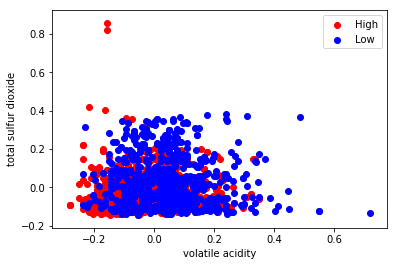

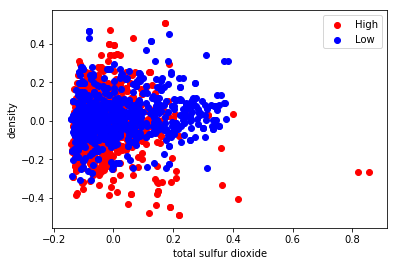

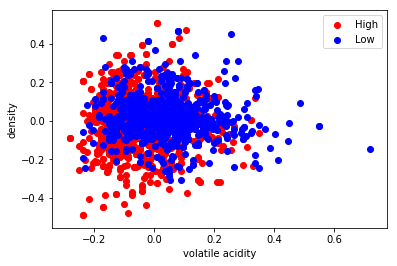

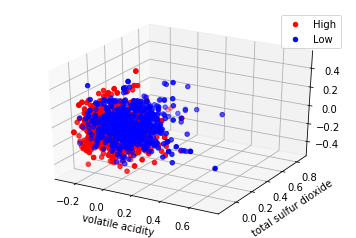

In [16]:
_3plot('volatile acidity','total sulfur dioxide','density')

Below we plot 3D plot for attributes that have positive correlation with **class**: **sulphates**, **alcohol** and **citric acid**.

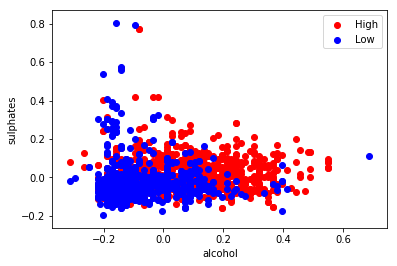

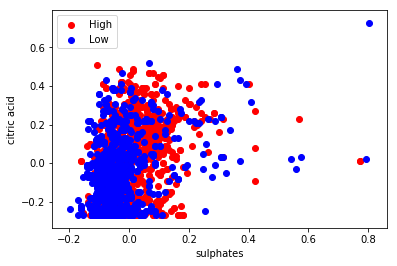

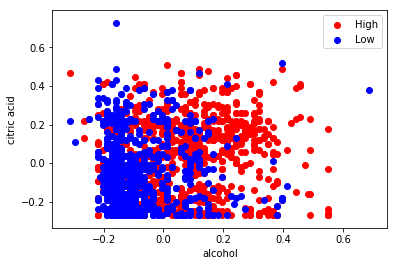

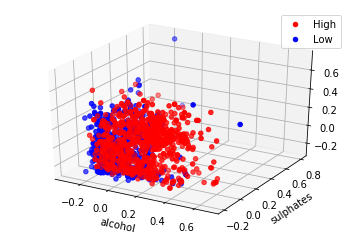

In [17]:
_3plot('alcohol','sulphates','citric acid')

## Part 3: Data Transformations

In this section, we make the transformations asked in the homework and see the effects of these transformations on validation accuracy. The function below takes dataset as input and prints the training and validation accuracy on a random forest classifier. The dataset is divided into the train and valid datasets (9:1). We first run this function on untransformed data so that we can compare the results of this section. The accuracy ranges from 0.78 - .8125. We plot double histogram (function **histo()**) for the attribute **total sulfur dioxide** to compare the changes after binning.

In [18]:
from sklearn.metrics import accuracy_score
def eval(data):
    x = data.drop('class', axis = 1)
    y = data['class']
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1, random_state = 42)
    cl = RandomForestClassifier(n_estimators=100)
    cl.fit(x_train, y_train)
    print('train accuracy: '+str(accuracy_score(y_train, cl.predict(x_train))))
    print('valid accuracy: '+str(accuracy_score(y_valid, cl.predict(x_valid))))
    

train accuracy: 1.0
valid accuracy: 0.825


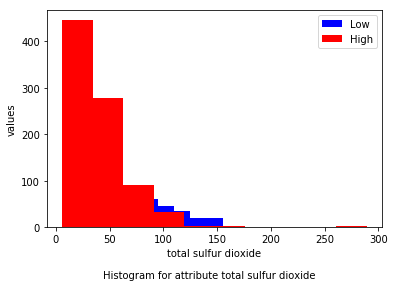

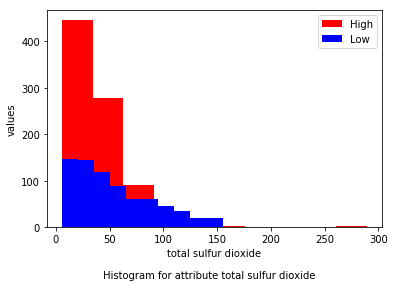

In [19]:
eval(data)
histo('total sulfur dioxide')

### 1. Equal interval width discretization

In this section we descretize the attribute **total sulfur dioxide** and analyze the changes.

In [20]:
temp = np.array(data['total sulfur dioxide'])
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
temp = temp.reshape(-1,1)
kbd.fit(temp)
temp = kbd.transform(temp).reshape(len(temp))

temp_data = data.copy()
temp_data['total sulfur dioxide'] = temp
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.81875


We see that the validation accuracy for this new dataset ranges from 0.80 to 0.8375, there is a slight improvement over the unbinned data. Below we find the correlation of new **total sulfur dioxide** with other attributes. The first list gives correlation values of unbinned data and the second gives correlation after binning. We see that the correlation values decrease for almost all the attributes. We also plot histograms for the new attribute. The correlation with **class** does not decrease much which can also be seen in the correlation tables.

fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64

fixed acidity          -0.104315
volatile acidity        0.070258
citric acid             0.051081
residual sugar          0.218864
chlorides               0.054250
free sulfur dioxide     0.645335
total sulfur dioxide    1.000000
density                 0.065841
pH                     -0.072032
sulphates               0.030095
alcohol                -0.193819
class                  -0.227878
Name: total sulfur dioxide, dtype: float64


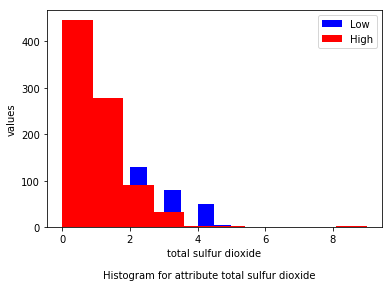

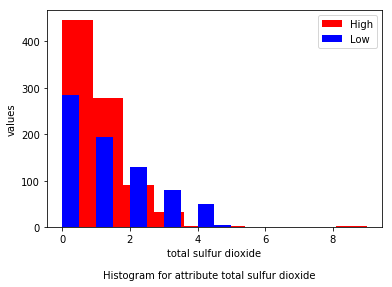

In [21]:
print(data.corr()['total sulfur dioxide'])
print()
print(temp_data.corr()['total sulfur dioxide'])
histo('total sulfur dioxide',temp_data)

### 2. Equal frequency discretization

In the output below we find that the correlation decreases significantly for some attributes like **class**, **residual sugar**. The validation accuracy ranges from 0.806 to 0.8375. From the **histo()** plot we can see that positive correlation relationship between **class** and **total sulfur dioxide** has reduced (this can be observed by comparing these plots to the ones plotted at the start of this section using unbinned data)

In [22]:
temp = np.array(data['total sulfur dioxide'])
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
temp = temp.reshape(-1,1)
kbd.fit(temp)
temp = kbd.transform(temp).reshape(len(temp))

temp_data = data.copy()
temp_data['total sulfur dioxide'] = temp
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.825


fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64

fixed acidity          -0.114125
volatile acidity        0.069310
citric acid            -0.002475
residual sugar          0.138939
chlorides               0.064033
free sulfur dioxide     0.714779
total sulfur dioxide    1.000000
density                 0.102113
pH                     -0.009227
sulphates               0.060486
alcohol                -0.221969
class                  -0.192337
Name: total sulfur dioxide, dtype: float64


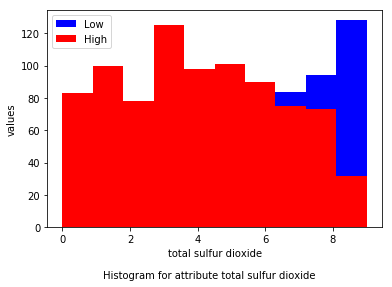

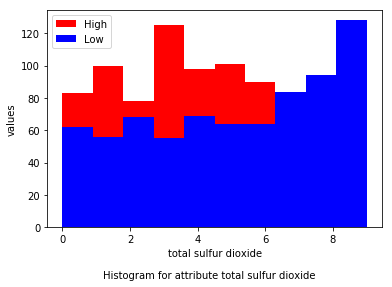

In [23]:
print(data.corr()['total sulfur dioxide'])
print()
print(temp_data.corr()['total sulfur dioxide'])
histo('total sulfur dioxide',temp_data)

### 3. Log transform on alcohol

In this section, we apply a log transform on the attribute **alcohol** and compare the changes (possible improvements) from the unprocessed data. We use the same metric: correlation with other attributes and overall validation accuracy of the new dataset. This dataset performs between 0.7935 to 0.83 on validation accuracy which is lower than the baseline we set at the start of the section.

We also observe that there is no significant change in the correlation of **alcohol** with other attributes upon the application of this transformation. This can also be observed from the histogram plots for this attribute. The first two plots represent **alcohol** attribute distribution (based on **class**) before log transform and the last two are generated after applying log transformation

In [24]:
temp_data = data.copy()
temp_data['alcohol'] = data['alcohol'].apply(np.log)
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.8125


fixed acidity          -0.061668
volatile acidity       -0.202288
citric acid             0.109903
residual sugar          0.042075
chlorides              -0.221141
free sulfur dioxide    -0.069408
total sulfur dioxide   -0.205654
density                -0.496180
pH                      0.205633
sulphates               0.093595
alcohol                 1.000000
class                   0.434751
Name: alcohol, dtype: float64

fixed acidity          -0.057959
volatile acidity       -0.201444
citric acid             0.108961
residual sugar          0.039034
chlorides              -0.225791
free sulfur dioxide    -0.070682
total sulfur dioxide   -0.213598
density                -0.490948
pH                      0.206209
sulphates               0.093669
alcohol                 1.000000
class                   0.438997
Name: alcohol, dtype: float64


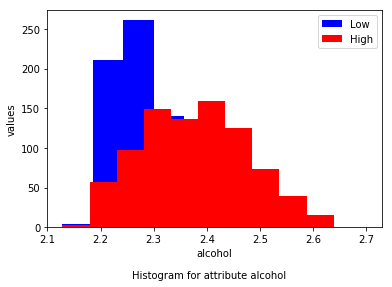

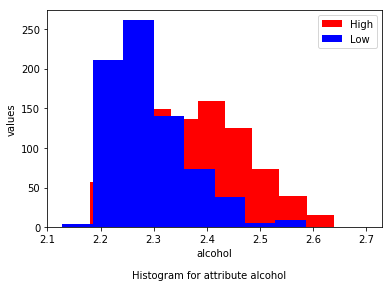

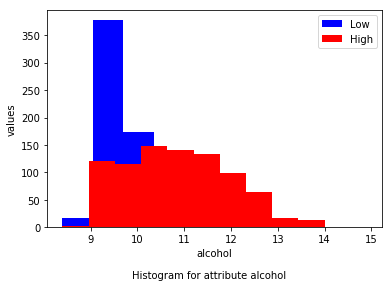

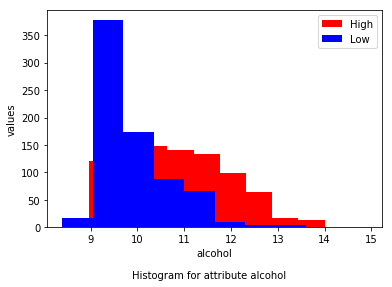

In [25]:
print(data.corr()['alcohol'])
print()
print(temp_data.corr()['alcohol'])
histo('alcohol',temp_data)
histo('alcohol')

### 4. Supervised discretization method - MDLP

In this section, we use a supervised discretization method, MDLP, for creating bins for **total sulfur dioxide** attribute. This method takes the **class** label into account while making decisions about the bin number (4 in this case) and threshold. The method was proposed by [Fayyad et al.](http://web.donga.ac.kr/kjunwoo/files/Multi%20interval%20discretization%20of%20continuous%20valued%20attributes%20for%20classification%20learning.pdf) in their work "Multi-interval discretization of continuous-valued attributes for classification learning". The algorithm implementation is available as a python plug-in.

We use the same methods for analyzing effects of discretization of **total sulfur dioxide** based on the MDLP method. The validation accuracy ranges from .806 to 0.825 which is an improvement over the unprocessed data, but not as good as the first two transformations. We observed from the histogram plots and the correlation table that the correlation between attributes **total sulfur dioxide** and **class**.

In [26]:
from mdlp.discretization import MDLP
tr = MDLP()
temp = np.array(data['total sulfur dioxide'])
temp = temp.reshape(-1,1)
tar = np.array(data['class'])
tar = tar.reshape(-1,1)
temp = tr.fit_transform(temp,tar).reshape(len(temp))
temp_data = data.copy()
temp_data['total sulfur dioxide'] = temp
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.80625


fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64

fixed acidity          -0.094813
volatile acidity        0.084158
citric acid             0.036862
residual sugar          0.219470
chlorides               0.009260
free sulfur dioxide     0.424141
total sulfur dioxide    1.000000
density                 0.042570
pH                     -0.094792
sulphates               0.013020
alcohol                -0.166514
class                  -0.247741
Name: total sulfur dioxide, dtype: float64


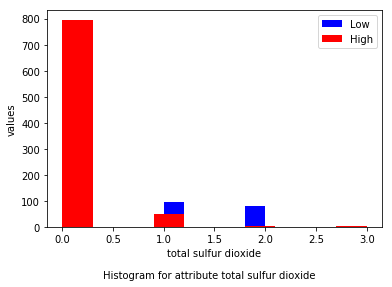

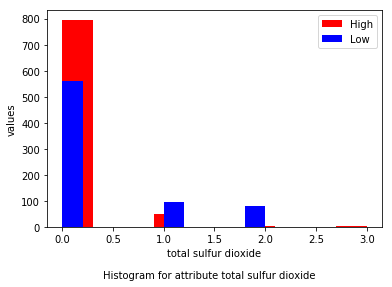

In [27]:
print(data.corr()['total sulfur dioxide'])
print()
print(temp_data.corr()['total sulfur dioxide'])
histo('total sulfur dioxide',temp_data)

### 5. Standardization and normalization transformations

In this section we apply standardization and normalization on **total sulfur dioxide**. We the StandardScalar and normalize functionalities provided by scikit-learn for this purpose. For both the transformation we use the same analysis technique followed in previous methods. We check the validation accuracy and correlation with other attributes and plot the **histo()** plots for visualization of correlation with **class**. For both standardization and normalization we find that there is no change in the correlation and histogram (distribution pattern). But there is a slight improvement in the validation accuracy.

#### Standardization

In [28]:
# Standardization
temp_data = data.copy()
scaler = StandardScaler(with_mean=True, with_std=True)
temp = np.array(data['total sulfur dioxide']).reshape(-1,1)
temp_data['total sulfur dioxide'] = scaler.fit_transform(temp).reshape(len(temp))
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.80625


fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64

fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64


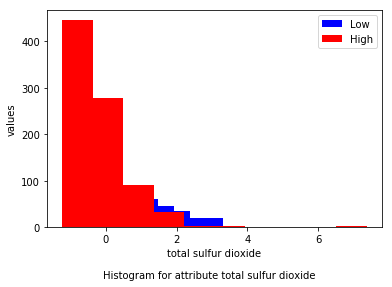

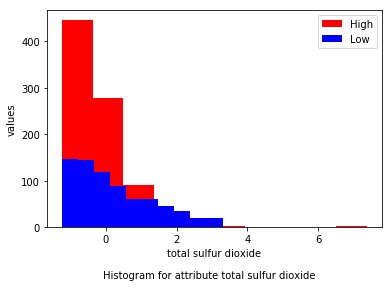

In [29]:
print(data.corr()['total sulfur dioxide'])
print()
print(temp_data.corr()['total sulfur dioxide'])
histo('total sulfur dioxide',temp_data)

#### Normalization

In [30]:
#Normalization
temp_data = data.copy()
temp = np.array(data['total sulfur dioxide']).reshape(-1,1)
temp_data['total sulfur dioxide'] = normalize(temp,axis=0).reshape(len(temp))
eval(temp_data)

train accuracy: 1.0
valid accuracy: 0.79375


fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64

fixed acidity          -0.113181
volatile acidity        0.076470
citric acid             0.035533
residual sugar          0.203028
chlorides               0.047400
free sulfur dioxide     0.667666
total sulfur dioxide    1.000000
density                 0.071269
pH                     -0.066495
sulphates               0.042947
alcohol                -0.205654
class                  -0.231963
Name: total sulfur dioxide, dtype: float64


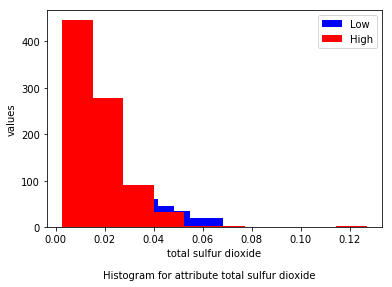

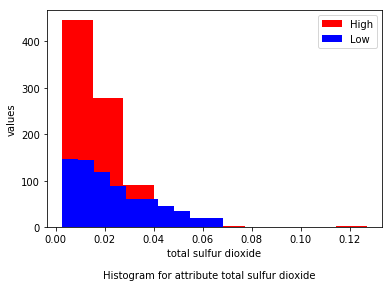

In [31]:
print(data.corr()['total sulfur dioxide'])
print()
print(temp_data.corr()['total sulfur dioxide'])
histo('total sulfur dioxide',temp_data)

## 4. Principle Component Analysis


### 1. Tool overview
In this section, we try to reduce the number of independent attributes and analyze the effect of dimensionality reduction. We use the PCA implementation in the scikit-learn library. PCA model is part of the **Decomposition** class in sklearn. The [documentation](https://scikitlearn.org/stable/modules/generated/sklearn.decomposition.PCA.html) gives the following attributes: **n_components, copy, whiten, svd_solver, tol, iterated_power, random_state**. We only use **n_components** in the attributes, which is the number of dimensions in the compressed data.

The function ***pca()*** below takes three arguments: dataset, the number of components and correlation (boolean, set as True if we need correlation matrix), and returns the PCA parameters (model) and the array with reduced data.

In [32]:
def pca(data,comp,corr):
    scaler = StandardScaler()
    data = np.array(data.drop('class',axis = 1))
    scaler.fit(data)
    if corr:
        data = scaler.transform(data)
    pca = PCA(n_components=comp)
    pca.fit_transform(data)
    print('variance left '+str(sum(pca.explained_variance_ratio_) * 100))
    return (pca,pca.transform(data))

### 2. Observations

Since the dataset is not normalized running PCA on the "raw" data will not give good results. Normalization of data [increases](https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca) the overall variance and improves PCA analysis. This is same as running PCA on correlation matrix instead of covariance matrix. The example below reduces dimensions of the data to 3 using correlation matrix and covariance matrix. We observe that using covariance matrix does not change vairance much even when the dimensions are reduced to 3, this is because attributes like **fixed acidity** and **chlorides** have different order. Using standardization improves the variance which can be observed in the second call to ***pca()***, using correlation matrix.

In [33]:
(pca_,red_dim) = pca(data,3,False)
(pca_,red_dim) = pca(data,3,True)

variance left 99.75344527989411
variance left 59.7780510822463


We also try to train the resulting data (after PCA reduction) on the random forest model we used in the previous analysis. For different values of variable 'components', we find that the model performs at par with the original dataset for 7 or greater number of components. For lower values like 3, the validation accuracy reduces to .76.

In [35]:
components = 7
(pca_,red_dim) = pca(data,components,True)
temp = pd.DataFrame(red_dim)
temp['class'] = data['class']
eval(temp)

variance left 90.83190640939523
train accuracy: 1.0
valid accuracy: 0.79375


### 3. Eigen Values and Eigen Vectors

In this part, we evaluate the eigenvectors and eigenvalues for a given number of components returned by the PCA algorithm. The variable component can be changed to any value from 1 to 11. The table gives Eigenvectors and the list gives eigenvalues in decreasing order.

In [36]:
components = 11
(pca_,red_dim) = pca(data,components,True)
temp = []
for i in range(components):
    temp.append('PC '+str(i+1))
print()
print(pd.DataFrame(np.transpose(pca_.components_),columns = temp))
print()
print(pd.DataFrame(pca_.explained_variance_,columns = ['Eigen Values']))

variance left 100.00000000000003

        PC 1      PC 2      PC 3      PC 4      PC 5      PC 6      PC 7  \
0   0.489314 -0.110503 -0.123302 -0.229617 -0.082614  0.101479 -0.350227   
1  -0.238584  0.274930 -0.449963  0.078960  0.218735  0.411449 -0.533735   
2   0.463632 -0.151791  0.238247 -0.079418 -0.058573  0.069593  0.105497   
3   0.146107  0.272080  0.101283 -0.372793  0.732144  0.049156  0.290663   
4   0.212247  0.148052 -0.092614  0.666195  0.246501  0.304339  0.370413   
5  -0.036158  0.513567  0.428793 -0.043538 -0.159152 -0.014000 -0.116596   
6   0.023575  0.569487  0.322415 -0.034577 -0.222465  0.136308 -0.093662   
7   0.395353  0.233575 -0.338871 -0.174500  0.157077 -0.391152 -0.170481   
8  -0.438520  0.006711  0.057697 -0.003788  0.267530 -0.522116 -0.025138   
9   0.242921 -0.037554  0.279786  0.550872  0.225962 -0.381263 -0.447469   
10 -0.113232 -0.386181  0.471673 -0.122181  0.350681  0.361645 -0.327651   

        PC 8      PC 9     PC 10     PC 11  
0  -0.17

### 4.  95% variance requirement

Reducing the dimensions to 9 brings down the variance to 97.8%. Reducing the dimensions further makes variance 94.67%. Therefore 8 dimensions are required for 95% (94.6%) variance.

In [37]:
(pca_,red_dim) = pca(data,9,True)

variance left 97.81007746827461


In [38]:
(pca_,red_dim) = pca(data,8,True)

variance left 94.67696731537688


### 5 . Plotting 2-dimension scatter plots

We reduce the dimension of data to 2 and then visualize the resulting data on two 2D scatter plots. The first plot simply plots all the data points on a graph and this does not give any useful information. The second plot divides the points based on the class labels. Red points represent samples with label 'High' and blue points are 'Low'. It can be seen that points from both the classes overall, which means these two dimensions cannot be used for classification. 

This is because of fact that 2-dimensions only preserve 45.68% variance of the data. Moreover, changing the component number to 2 in the model evaluation code (Observations section), we find that the validation accuracy reduces to .72. Therefore, though reducing dimensions to 2 facilitates visualization, it causes loss of data.

variance left 45.68220118429408


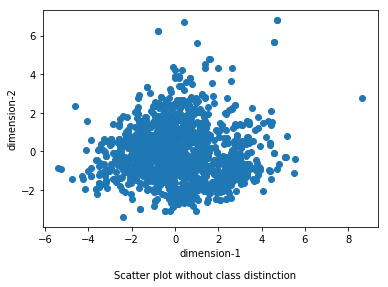

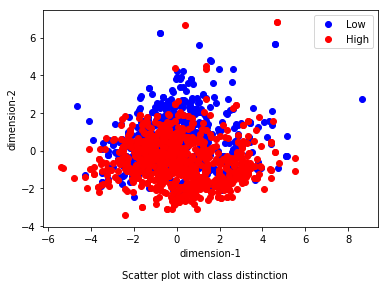

In [39]:
(pca_,_2d) = pca(data,2,True)
x =[]
y = []
X = []
Y = []
for i in range(len(data)):
    if data['class'].iloc[i]==0:
        x.append(_2d[i][0])
        y.append(_2d[i][1])
    else:
        X.append(_2d[i][0])
        Y.append(_2d[i][1])

fig = plt.figure()
plt.scatter(_2d[:,0],_2d[:,1]);
plt.xlabel('dimension-1')
plt.ylabel('dimension-2')
fig.text(.5, -0.05, 'Scatter plot without class distinction', ha='center')
plt.show()

fig = plt.figure()
plt.scatter(x,y,color='blue',label = 'Low');
plt.scatter(X,Y,color='red', label = 'High');
plt.xlabel('dimension-1')
plt.ylabel('dimension-2')
plt.legend()
fig.text(.5, -0.05, 'Scatter plot with class distinction', ha='center')
plt.show()